In [ ]:
!python -m pip install pyyaml==5.1
!pip install imgaug==0.2.6
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)
!pip install layoutparser
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 274 kB 27.8 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=d32dc4fe2fe0ea34983b8002689ab88899358d8b5289d149579fd8f4d7c9f539
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 631 kB 27.0 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654017 sha256=a99ee1aaee06f856d8445a389584a55e1047e9a20b7d9d760f873c006171909d
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef01

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pycocotools.coco import COCO
import layoutparser as lp
import random
import cv2
import torch
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
import os
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog


In [ ]:
def load_coco_annotations(annotations, coco=None):
    layout = lp.Layout()

    for ele in annotations:

        x, y, w, h = ele['bbox']

        layout.append(
            lp.TextBlock(
                block = lp.Rectangle(x, y, w+x, h+y),
                type  = ele['category_id'] if coco is None else coco.cats[ele['category_id']]['name'],
                id = ele['id']
            )
        )

    return layout

In [ ]:
COCO_ANNO_PATH = 'drive/MyDrive/train-0/publaynet/val1.json'
COCO_IMG_PATH  = 'drive/MyDrive/pdf2img/content/pdf2img'
coco = COCO(COCO_ANNO_PATH)

loading annotations into memory...
Done (t=0.44s)
creating index...
index created!


In [ ]:
color_map = {
    'section':   'red',
}

{'id': 40, 'file_name': '2699.tiff', 'height': 1000, 'width': 800}
[44.773109243697476, 33.479809976247, 679.02, 148.42]


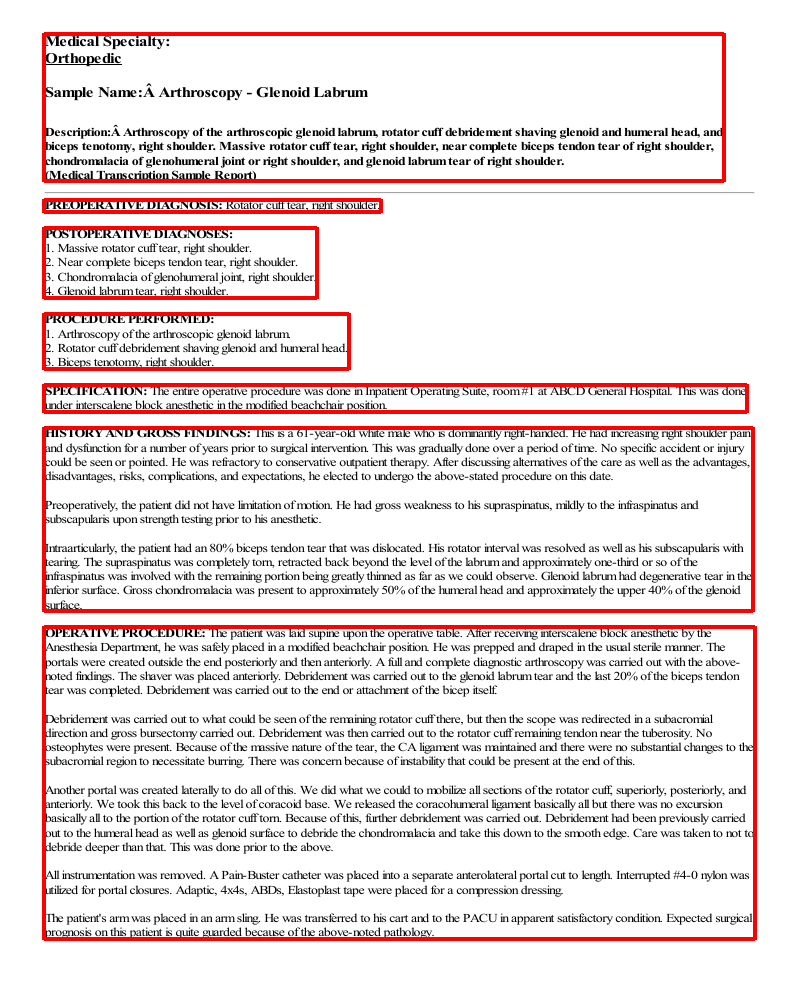

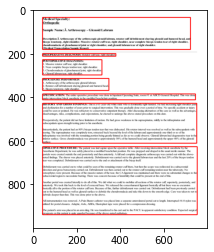

In [ ]:
import matplotlib.pyplot as plt

for image_id in random.sample(coco.imgs.keys(), 1):
    image_info = coco.imgs[image_id]
    annotations = coco.loadAnns(coco.getAnnIds([image_id]))
    image = cv2.imread(f'{COCO_IMG_PATH}/{image_info["file_name"]}')
    layout = load_coco_annotations(annotations, coco)
    print(image_info)
    viz = lp.draw_box(image, layout, color_map=color_map)
    print(annotations[0]["bbox"])
    plt.imshow(viz)
    display(viz) # show the results

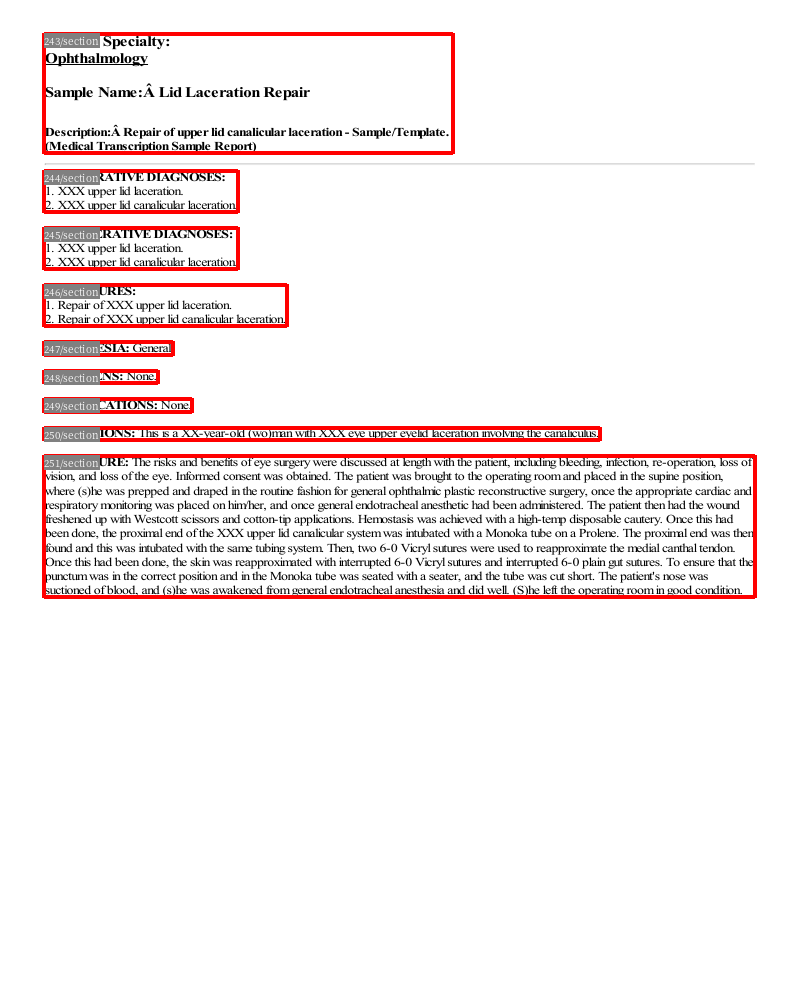

In [ ]:
lp.draw_box(image,
              [b.set(id=f'{b.id}/{b.type}') for b in layout],
              color_map=color_map,
              show_element_id=True, id_font_size=10,
              id_text_background_color='grey',
              id_text_color='white')

In [ ]:
register_coco_instances("Dataset", {}, COCO_ANNO_PATH, COCO_IMG_PATH)

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("Dataset",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH =50   # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/19 20:23:58 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[06/19 20:24:01 d2.engine.train_loop]: Starting training from iteration 0
ERROR [06/19 20:24:10 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/detectron2/engine/train_loop.py", line 149, in train
    self.run_step()
  File "/usr/local/lib/python3.7/dist-packages/detectron2/engine/defaults.py", line 494, in run_step
    self._trainer.run_step()
  File "/usr/local/lib/python3.7/dist-packages/detectron2/engine/train_loop.py", line 274, in run_step
    loss_dict = self.model(data)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/detectron2/modeling/meta_arch/rcnn.py", line 158, in forward
    features = self.backbone(images.tensor)
  File "/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py", line 1110, in _call_impl
    return forward_call(*input, **kwa

RuntimeError: ignored

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
import os
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[06/19 19:37:59 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (256,) (256,) (256,) (256,) (256,8,3,3)         |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

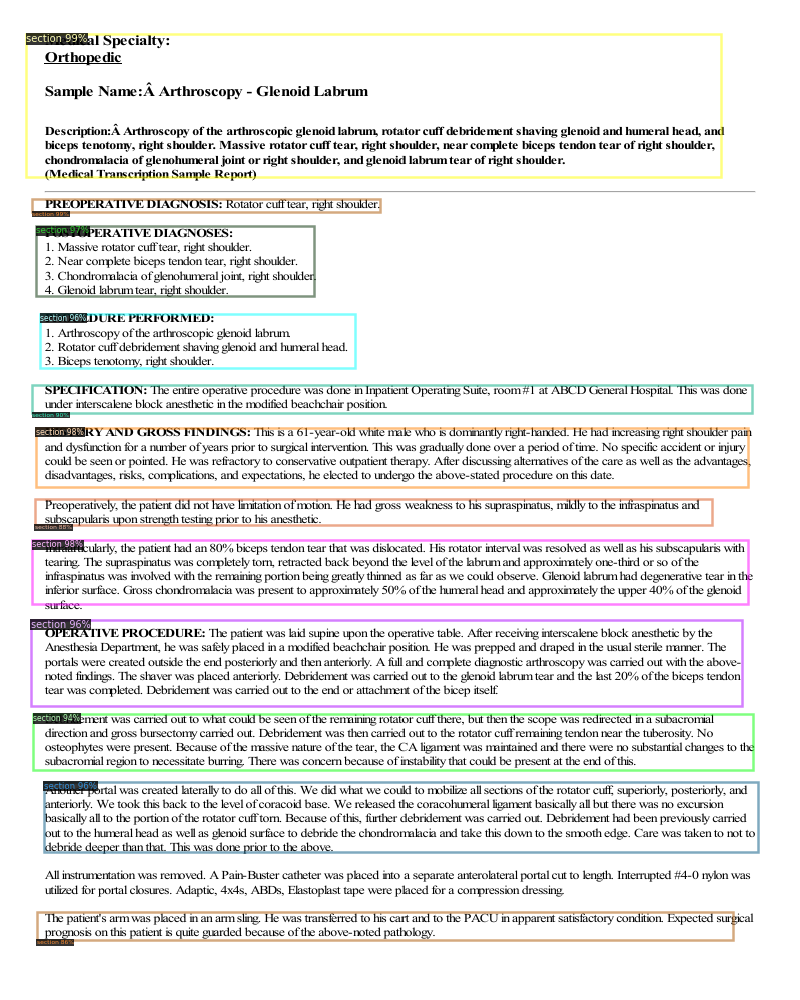

In [ ]:
from google.colab.patches import cv2_imshow
metadata=MetadataCatalog.get("Dataset_Val")
from detectron2.utils.visualizer import Visualizer
im = cv2.imread(COCO_IMG_PATH+"/2699.tiff")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
               metadata=metadata, 
               scale=1, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])